## Import

In [1]:
# notebooky stuff
%load_ext autoreload
%autoreload 2
from IPython.display import display

import sys 
sys.path.append('../src/modules')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import eumf_data, eumf_eval, eumf_pipeline
from sklearn import preprocessing, linear_model, model_selection, dummy

from typing import Optional, Iterable

# pandas pretty output
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

## Data

### Load all data

In [2]:
# list of countries
countries = eumf_data.get_countries()
countries.remove("CY")

# migration rates
df_values = eumf_data.load_registrations_from_csv(impute_missing=True, countries=countries)

# google trends
df_trends = eumf_data.load_trends_from_csv(countries=countries)
keyword_ids = df_trends.columns.levels[0].tolist()

# macroeconomic data
df_gdp = eumf_data.read_gdp(countries=countries)
df_unempl = eumf_data.read_unempl(countries=countries)

country_combinations = [
    # ["GR", "CY"],
    ["LV", "LT", "EE"],
    ["BE", "NL", "LU"],
    ["CZ", "SK"],
    ["SE", "FI", "DK"],
    ["AT", "CH"]
]

panel = df_values.join(df_trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_comb = eumf_data.combine_countries(panel, combinations=country_combinations)
panel_comb_3m = eumf_data.combine_countries(panel_3m, combinations=country_combinations)
df_gdp_comb = eumf_data.combine_countries(df_gdp, combinations=country_combinations)
df_unempl_comb = eumf_data.combine_countries(
    df_unempl, combinations=country_combinations, average=True
)
# note: strictly, unweighted average is wrong for unemployment, but should work in most cases

panel_comb_3m_macro = panel_comb_3m.join(df_gdp_comb).join(df_unempl_comb)

panel_comb_3m_macro["2017":"2018"]


10                                                                                                                       11                                                                                                                                            112                                                                                                               ...   value                                                                                                                                     gdp                                                                                                                                                unempl                                                                                                      
country     AT+CH  BE+NL+LU  BG  CZ+SK    ES      FR      GB    GR   HR   HU   IE     IT   LV+LT+EE    PL    PT   RO  SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR     HR      HU      IE      IT   LV+LT+EE    PL      PT      RO   SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK      ES      FR      GB      GR      HR      HU      IE      IT   LV+LT+EE    PL    ...     ES        FR        GB        GR        HR        HU       IE        IT     LV+LT+EE     PL        PT        RO     SE+FI+DK    SI     AT+CH   BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR      HR      HU      IE       IT   LV+LT+EE    PL      PT      RO   SE+FI+DK    SI   AT+CH  BE+NL+LU  BG  CZ+SK   ES   FR   GB    GR    HR   HU   IE    IT  LV+LT+EE  PL   PT   RO  SE+FI+DK  SI 
date                                                                                                                                                                                                                                                                                                                                                                                                   ...                                                                                                                                                                                                                                                                                                                                                                                                            
2017-03-31  10.524  16.048   0.0   0.0  26.667  21.857  21.381  0.0  0.0  0.0  0.0  14.095    0.0     6.095  0.0  0.0  21.286   0.0  34.714  60.190    2.190  10.857  38.714  29.810  53.381  10.000  0.000   0.619  11.095  22.048    0.0    11.952  12.714  11.571  26.524   0.0  97.190  178.952  42.238  127.048  33.143  63.333  47.286   9.000  63.095  62.810  59.333  14.905  179.429  39.524  ...  1689.000  1268.333  1080.333  2327.333  4459.000  3747.667  156.000  5255.333  1396.333  12264.667  866.333  18186.333  654.333  420.333  28780.0  42970.0  1510.0  7620.0  5950.0  8450.0  9080.0  3760.0  2590.0  2820.0  14640.0  6800.0  10490.0  2760.0  4520.0  1850.0  33780.0  4790.0  2.85    6.433   6.6  6.00  18.2  9.6  4.6  22.4  12.7  4.3  7.4  11.6   7.333   5.3  9.8  5.3   7.167   7.4
2017-06-30   4.952  14.810   0.0   0.0  21.048  13.952  18.857  0.0  0.0  0.0  0.0  15.286    0.0     6.524  0.0  0.0  27.714   0.0  39.286  61.619   10.619   7.714  24.381  27.952  55.714   4.714  2.333   7.095  20.619  17.286    0.0    13.810  23.143  11.143  32.857   0.0  85.619  168.905  35.190   83.429  23.810  57.857  48.000  11.905  33.048  27.905  62.810  14.286  126.667  21.476  ...  1427.667  1023.333  1049.000  2113.333  4121.333  3637.667  164.667  4699.000  1407.000  12940.000  609.667  19264.000  520.333  365.000  29250.0  44540.0  1800.0  8470.0  6330.0  8560.0  8980.0  4120.0  2990.0  3200.0  14700.0  7140.0  11780.0  2960.0  4790.0  2200.0  35590.0  5260.0  2.70    5.867   6.2  5.75  17.3  9.6  4.4  21.8  11.5  4.3  6.7  11.3   7.667   5.1  9.2  4.9   7.133   6.6
2017-09-30   4.905  16.095   0.0   0.0  12.429  21.048  16.

## Experiments

### Common definitions

In [3]:
T_MIN = "2010"
T_MAX = "2019"

T_TEST_MIN = "2014"
T_TEST_MAX = "2014"

cv_default = model_selection.KFold(n_splits=8, shuffle=False)
cv_random = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

In [4]:
class LinearPredictionModel(linear_model.LinearRegression):
    """
    This model is for prediction only.  It has no fit method.
    You can initialize it with fixed values for coefficients 
    and intercepts.  

    Parameters
    ----------
    coef, intercept : arrays
        See attribute descriptions below.

    Attributes
    ----------
    coef_ : array of shape (n_features, ) or (n_targets, n_features)
        Coefficients of the linear model.  If there are multiple targets
        (y 2D), this is a 2D array of shape (n_targets, n_features), 
        whereas if there is only one target, this is a 1D array of 
        length n_features.
    intercept_ : float or array of shape of (n_targets,)
        Independent term in the linear model.
    """

    def __init__(self, coef=None, intercept=None):
        self.intercept = intercept
        self.coef = coef
        if coef is not None:
            coef = np.array(coef)
            if intercept is None:
                intercept = np.zeros(coef.shape[0])
            else:
                intercept = np.array(intercept)
            assert coef.shape[0] == intercept.shape[0]
        else:
            if intercept is not None:
                raise ValueError("Provide coef only or both coef and intercept")
        self.intercept_ = intercept
        self.coef_ = coef

    def fit(self, X, y):
        ...
        # """This model does not have a fit method."""
        # raise NotImplementedError("model is only for prediction")


### Dummy models

In [5]:
### TRAINING

model_names = ["constant", "previous_1", "previous_5"]
lags = [[1], [1], [5]]
regressors = [
    dummy.DummyRegressor(strategy="constant", constant=0),
    LinearPredictionModel(np.array([1.0]), np.array([0.0])),
    LinearPredictionModel(np.array([1.0]), np.array([0.0])),
]


tuners = []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {}

for reg, lag in zip(regressors, lags):

    labeled = eumf_pipeline.prepare_data(
        panel_comb, columns=["value"], lags=lag, t_min=T_MIN, t_max=T_MAX
    )
    transformed = eumf_pipeline.transform_data(labeled, delta=12)
    train, test = eumf_pipeline.split_data(
        transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
    )
    train_stacked, test_stacked = eumf_pipeline.stack_data(train, test)

    train_stackeds.append(train_stacked)
    train_unstackeds.append(train)
    test_stackeds.append(test_stacked)

    tuner = eumf_pipeline.train_reg_model(
        train_stacked,
        reg=reg,
        dummy_encoder="drop",
        params=params,
        scoring=eumf_eval.scorer_rmse,
    )
    tuners.append(tuner)

    cv_score = eumf_eval.score_cv(tuner.best_estimator_, train_stacked, cv=cv_default,)
    cv_scores.append(cv_score)

    test_score = eumf_eval.score_test(tuner.best_estimator_, test_stacked,)
    test_scores.append(test_score)


In [6]:
eumf_eval.agg_multiple_test_scores(test_scores, model_names)

,mae,rmse,explained_variance,r2_mod,delta_mae
constant,-0.164,-0.256,0.000,0.000,0.000
previous_1,-0.121,-0.159,0.570,0.614,0.042
previous_5,-0.154,-0.219,0.211,0.271,0.010


In [8]:
eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)


fit_time                   score_time               test_mae               test_rmse               test_explained_variance               test_r2_mod               test_delta_mae              
             mean    std      sem        mean     std    sem     mean    std    sem      mean    std    sem             mean           std    sem       mean     std    sem        mean       std    sem  
constant     0.014   0.010  3.413e-03    0.014    0.003  0.001  -0.137   0.072  0.026   -0.185   0.093  0.033           0.000          0.000  0.000     0.000    0.000  0.000      0.000      0.000  0.000
previous_1   0.007   0.002  7.883e-04    0.016    0.008  0.003  -0.107   0.015  0.005   -0.143   0.024  0.009           0.021          0.392  0.139     0.145    0.471  0.167      0.030      0.062  0.022
previous_5   0.007   0.002  7.892e-04    0.016    0.006  0.002  -0.127   0.030  0.011   -0.172   0.046  0.016          -0.251          0.311  0.110    -0.085    0.441  0.156      0.011      0.051  0.018

#### Performance by year (CV+test)

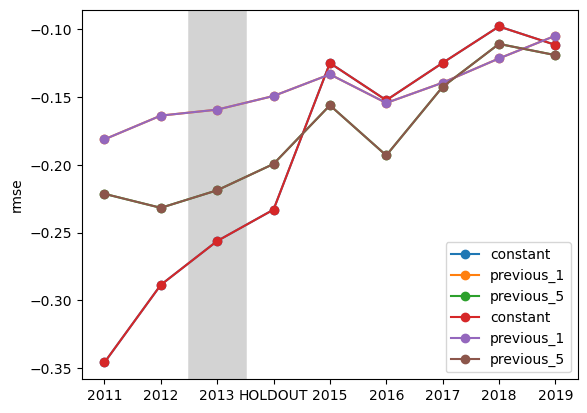

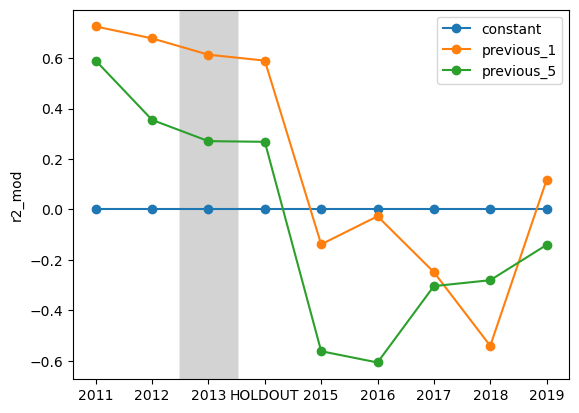

In [10]:
indices = [0, 1, 2]
metrics = ["rmse", "r2_mod"]

fold_labels = [2011, 2012, 2013, "HOLDOUT", 2015, 2016, 2017, 2018, 2019]

for m in metrics:
    eumf_eval.cv_performance_plot(
        cv_scores,
        m,
        indices=indices,
        run_labels=model_names,
        fold_labels=fold_labels,
        test_scores=test_scores,
        test_pos=2,
    )
    plt.show()


#### Performance by country

##### model: const

In [11]:
i = 0

reg = tuners[i].best_estimator_

test_scores_c = eumf_eval.score_test_countries(reg, test_stackeds[i])
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="r2_mod", ascending=False))

Holdout scores per country:


,mae,rmse,explained_variance,r2_mod,delta_mae
AT+CH,-0.076,-0.089,0.0,0.0,0.0
BE+NL+LU,-0.081,-0.112,0.0,0.0,0.0
SE+FI+DK,-0.116,-0.128,0.0,0.0,0.0
RO,-0.355,-0.371,0.0,0.0,0.0
PT,-0.202,-0.243,0.0,0.0,0.0
PL,-0.064,-0.084,0.0,0.0,0.0
LV+LT+EE,-0.107,-0.123,0.0,0.0,0.0
IT,-0.205,-0.216,0.0,0.0,0.0
IE,-0.112,-0.130,0.0,0.0,0.0
HU,-0.099,-0.109,0.0,0.0,0.0


In [12]:
i = 0
reg = tuners[i].best_estimator_

cv_scores_c = eumf_eval.score_cv_countries(reg, train_unstackeds[i], cv_random)
print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0, use_quantiles=False)
display(cv_scores_c_agg.sort_values(by=("r2_mod", "mean"), ascending=False))

CV scores per country:


mae                  rmse                explained_variance           r2_mod           delta_mae          
          mean   std    sem    mean   std    sem          mean        std  sem   mean  std  sem     mean   std  sem 
AT+CH    -0.077  0.025  0.011 -0.111  0.048  0.022         0.0         0.0  0.0   0.0   0.0  0.0     0.0    0.0  0.0
BE+NL+LU -0.074  0.006  0.003 -0.093  0.013  0.006         0.0         0.0  0.0   0.0   0.0  0.0     0.0    0.0  0.0
SE+FI+DK -0.084  0.017  0.008 -0.106  0.017  0.008         0.0         0.0  0.0   0.0   0.0  0.0     0.0    0.0  0.0
RO       -0.132  0.026  0.012 -0.161  0.034  0.015         0.0         0.0  0.0   0.0   0.0  0.0     0.0    0.0  0.0
PT       -0.164  0.034  0.015 -0.207  0.038  0.017         0.0         0.0  0.0   0.0   0.0  0.0     0.0    0.0  0.0
PL       -0.136  0.012  0.005 -0.190  0.033  0.015         0.0         0.0  0.0   0.0   0.0  0.0     0.0    0.0  0.0
LV+LT+EE -0.132  0.042  0.019 -0.173  0.065  0.029         0.0         0.0  0.0   0.0   0.0  0.0     0.0    0.0  0.0
IT       -0.149  0.039  0.018 -0.191  0.043  0.019         0.0         0.0  0.0   0.0   0.0  0.0     0.0    0.0  0.0
IE       -0.131  0.014  0.006 -0.168  0.017  0.007         0.0         0.0  0.0   0.0   0.0  0.0     0.0    0.0  0.0
HU       -0.160  0.029  0.013 -0.210  0.048  0.021         0.0         0.0  0.0   0.0   0.0  0.0     0.0    0.0  0.0
HR       -0.199  0.043  0.019 -0.300  0.095  0.042         0.0         0.0  0.0   0.0   0.0  0.0     0.0    0.0  0.0
GR       -0.198  0.057  0.025 -0.284  0.097  0.043         0.0         0.0  0.0   0.0   0.0  0.0     0.0    0.0  0.0
GB       -0.078  0.018  0.008 -0.104  0.032  0.014         0.0         0.0  0.0   0.0   0.0  0.0     0.0    0.0  0.0
FR       -0.067  0.005  0.002 -0.085  0.008  0.004         0.0         0.0  0.0   0.0   0.0  0.0     0.0    0.0  0.0
ES       -0.203  0.048  0.022 -0.255  0.061  0.027         0.0         0.0  0.0   0.0   0.0  0.0     0.0    0.0  0.0
CZ+SK    -0.123  0.026  0.012 -0.175  0.044  0.020         0.0         0.0  0.0   0.0   0.0  0.0     0.0    0.0  0.0
BG       -0.099  0.020  0.009 -0.133  0.034  0.015         0.0         0.0  0.0   0.0   0.0  0.0     0.0    0.0  0.0
SI       -0.265  0.069  0.031 -0.357  0.105  0.047         0.0         0.0  0.0   0.0   0.0  0.0     0.0    0.0  0.0

##### model: random walk

In [13]:
i = 1

reg = tuners[i].best_estimator_

test_scores_c = eumf_eval.score_test_countries(reg, test_stackeds[i])
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="r2_mod", ascending=False))

Holdout scores per country:


,mae,rmse,explained_variance,r2_mod,delta_mae
IT,-0.054,-0.063,0.176,0.915,0.151
HR,-0.228,-0.314,0.538,0.856,0.462
RO,-0.143,-0.165,-1.393,0.802,0.212
BG,-0.113,-0.143,-1.130,0.762,0.163
PT,-0.163,-0.191,-1.007,0.379,0.039
LV+LT+EE,-0.087,-0.107,-2.030,0.248,0.019
GR,-0.070,-0.090,-1.685,0.209,0.015
CZ+SK,-0.105,-0.126,-1.298,-0.259,-0.017
HU,-0.096,-0.125,-0.367,-0.321,0.003
SI,-0.193,-0.217,-0.654,-0.479,-0.041


In [14]:
i = 1
reg = tuners[i].best_estimator_

cv_scores_c = eumf_eval.score_cv_countries(reg, train_unstackeds[i], cv_random)
print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0, use_quantiles=False)
display(cv_scores_c_agg.sort_values(by=("r2_mod", "mean"), ascending=False))

CV scores per country:


mae                  rmse                explained_variance               r2_mod               delta_mae              
          mean   std    sem    mean   std    sem          mean         std    sem    mean   std    sem      mean    std    sem  
IT       -0.070  0.010  0.005 -0.087  0.009  0.004        0.693        0.108  0.048  0.773  0.092  0.041    0.079   0.031  0.014
ES       -0.097  0.017  0.008 -0.125  0.019  0.008        0.600        0.331  0.148  0.700  0.228  0.102    0.106   0.055  0.025
GR       -0.099  0.019  0.009 -0.122  0.019  0.008        0.610        0.499  0.223  0.655  0.463  0.207    0.099   0.067  0.030
HR       -0.134  0.012  0.005 -0.177  0.026  0.012        0.564        0.197  0.088  0.596  0.201  0.090    0.065   0.037  0.017
SI       -0.168  0.026  0.012 -0.233  0.046  0.020        0.365        0.406  0.181  0.474  0.296  0.132    0.097   0.076  0.034
CZ+SK    -0.093  0.018  0.008 -0.125  0.028  0.012        0.434        0.199  0.089  0.456  0.203  0.091    0.030   0.013  0.006
HU       -0.118  0.007  0.003 -0.154  0.031  0.014        0.287        0.496  0.222  0.413  0.259  0.116    0.042   0.030  0.013
PT       -0.122  0.027  0.012 -0.149  0.020  0.009        0.266        0.542  0.243  0.405  0.397  0.178    0.041   0.045  0.020
RO       -0.096  0.017  0.007 -0.127  0.014  0.006       -0.122        0.397  0.178  0.296  0.323  0.145    0.036   0.036  0.016
PL       -0.108  0.010  0.004 -0.159  0.028  0.013        0.197        0.152  0.068  0.291  0.138  0.062    0.028   0.012  0.005
BG       -0.090  0.017  0.008 -0.113  0.023  0.010       -0.227        0.874  0.391  0.104  0.625  0.280    0.008   0.027  0.012
LV+LT+EE -0.107  0.013  0.006 -0.141  0.021  0.009        0.059        0.721  0.322  0.076  0.746  0.334    0.025   0.030  0.013
IE       -0.130  0.033  0.015 -0.163  0.037  0.017       -0.075        0.544  0.243 -0.018  0.531  0.237    0.001   0.037  0.017
GB       -0.092  0.014  0.006 -0.113  0.020  0.009       -0.739        0.534  0.239 -0.268  0.407  0.182   -0.013   0.009  0.004
SE+FI+DK -0.112  0.026  0.012 -0.139  0.038  0.017       -0.864        0.752  0.336 -0.771  0.665  0.297   -0.028   0.016  0.007
FR       -0.086  0.019  0.009 -0.114  0.020  0.009       -1.018        0.832  0.372 -0.897  0.752  0.336   -0.019   0.022  0.010
AT+CH    -0.102  0.028  0.012 -0.140  0.045  0.020       -1.067        1.365  0.610 -0.930  1.102  0.493   -0.026   0.022  0.010
BE+NL+LU -0.104  0.010  0.004 -0.132  0.015  0.007       -1.091        0.510  0.228 -1.019  0.285  0.128   -0.029   0.005  0.002

##### model: random walk with delay

In [15]:
i = 2

reg = tuners[i].best_estimator_

test_scores_c = eumf_eval.score_test_countries(reg, test_stackeds[i])
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="r2_mod", ascending=False))

Holdout scores per country:


,mae,rmse,explained_variance,r2_mod,delta_mae
IT,-0.084,-0.103,-0.762,0.772,0.121
RO,-0.198,-0.220,-3.042,0.647,0.157
HR,-0.508,-0.620,-0.373,0.440,0.182
LV+LT+EE,-0.092,-0.103,-1.835,0.296,0.015
BG,-0.205,-0.247,-3.832,0.288,0.071
GR,-0.092,-0.103,-1.902,-0.038,-0.007
CZ+SK,-0.103,-0.121,-1.203,-0.171,-0.015
PT,-0.227,-0.275,-2.662,-0.282,-0.025
FR,-0.088,-0.098,-1.453,-0.534,-0.023
AT+CH,-0.100,-0.110,-1.360,-0.542,-0.024


In [16]:
i = 2
reg = tuners[i].best_estimator_

cv_scores_c = eumf_eval.score_cv_countries(reg, train_unstackeds[i], cv_random)
print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0, use_quantiles=False)
display(cv_scores_c_agg.sort_values(by=("r2_mod", "mean"), ascending=False))

CV scores per country:


mae                  rmse                explained_variance               r2_mod               delta_mae               
          mean   std    sem    mean   std    sem          mean         std    sem    mean   std    sem      mean     std    sem  
IT       -0.082  0.016  0.007 -0.105  0.023  0.010        0.510        0.309  0.138  0.608  0.328  0.147  6.663e-02  0.051  0.023
ES       -0.127  0.026  0.012 -0.156  0.030  0.014        0.452        0.279  0.125  0.562  0.221  0.099  7.566e-02  0.056  0.025
GR       -0.135  0.022  0.010 -0.175  0.036  0.016        0.335        0.646  0.289  0.386  0.624  0.279  6.281e-02  0.067  0.030
HU       -0.129  0.023  0.010 -0.163  0.029  0.013        0.196        0.442  0.198  0.320  0.311  0.139  3.137e-02  0.020  0.009
PT       -0.132  0.016  0.007 -0.163  0.024  0.011        0.181        0.393  0.176  0.308  0.338  0.151  3.146e-02  0.041  0.018
HR       -0.185  0.050  0.022 -0.266  0.105  0.047        0.160        0.171  0.077  0.219  0.187  0.084  1.370e-02  0.022  0.010
SI       -0.232  0.057  0.026 -0.310  0.072  0.032        0.048        0.324  0.145  0.168  0.388  0.174  3.254e-02  0.052  0.023
RO       -0.107  0.010  0.005 -0.141  0.009  0.004       -0.258        0.338  0.151  0.162  0.335  0.150  2.458e-02  0.024  0.011
PL       -0.136  0.021  0.009 -0.182  0.028  0.013       -0.114        0.239  0.107  0.064  0.161  0.072  8.919e-04  0.016  0.007
IE       -0.138  0.026  0.011 -0.162  0.032  0.014       -0.196        0.574  0.257  0.035  0.321  0.143 -6.952e-03  0.024  0.011
CZ+SK    -0.133  0.027  0.012 -0.179  0.043  0.019       -0.228        0.304  0.136 -0.077  0.194  0.087 -1.064e-02  0.019  0.008
LV+LT+EE -0.128  0.030  0.014 -0.174  0.048  0.021       -0.251        0.515  0.230 -0.186  0.501  0.224  4.449e-03  0.029  0.013
BG       -0.102  0.010  0.005 -0.135  0.013  0.006       -0.515        0.724  0.324 -0.247  0.704  0.315 -3.296e-03  0.026  0.012
SE+FI+DK -0.106  0.011  0.005 -0.132  0.011  0.005       -0.662        0.475  0.212 -0.677  0.689  0.308 -2.176e-02  0.017  0.008
GB       -0.102  0.007  0.003 -0.131  0.010  0.005       -1.689        1.302  0.582 -0.817  0.695  0.311 -2.395e-02  0.017  0.008
BE+NL+LU -0.104  0.031  0.014 -0.133  0.033  0.015       -1.166        0.579  0.259 -1.028  0.536  0.240 -2.945e-02  0.026  0.012
FR       -0.097  0.028  0.012 -0.122  0.034  0.015       -1.188        0.757  0.339 -1.112  0.875  0.391 -2.983e-02  0.023  0.010
AT+CH    -0.103  0.025  0.011 -0.155  0.057  0.026       -1.336        1.915  0.857 -1.384  1.944  0.869 -2.630e-02  0.013  0.006

#### Plot prediction 

##### const

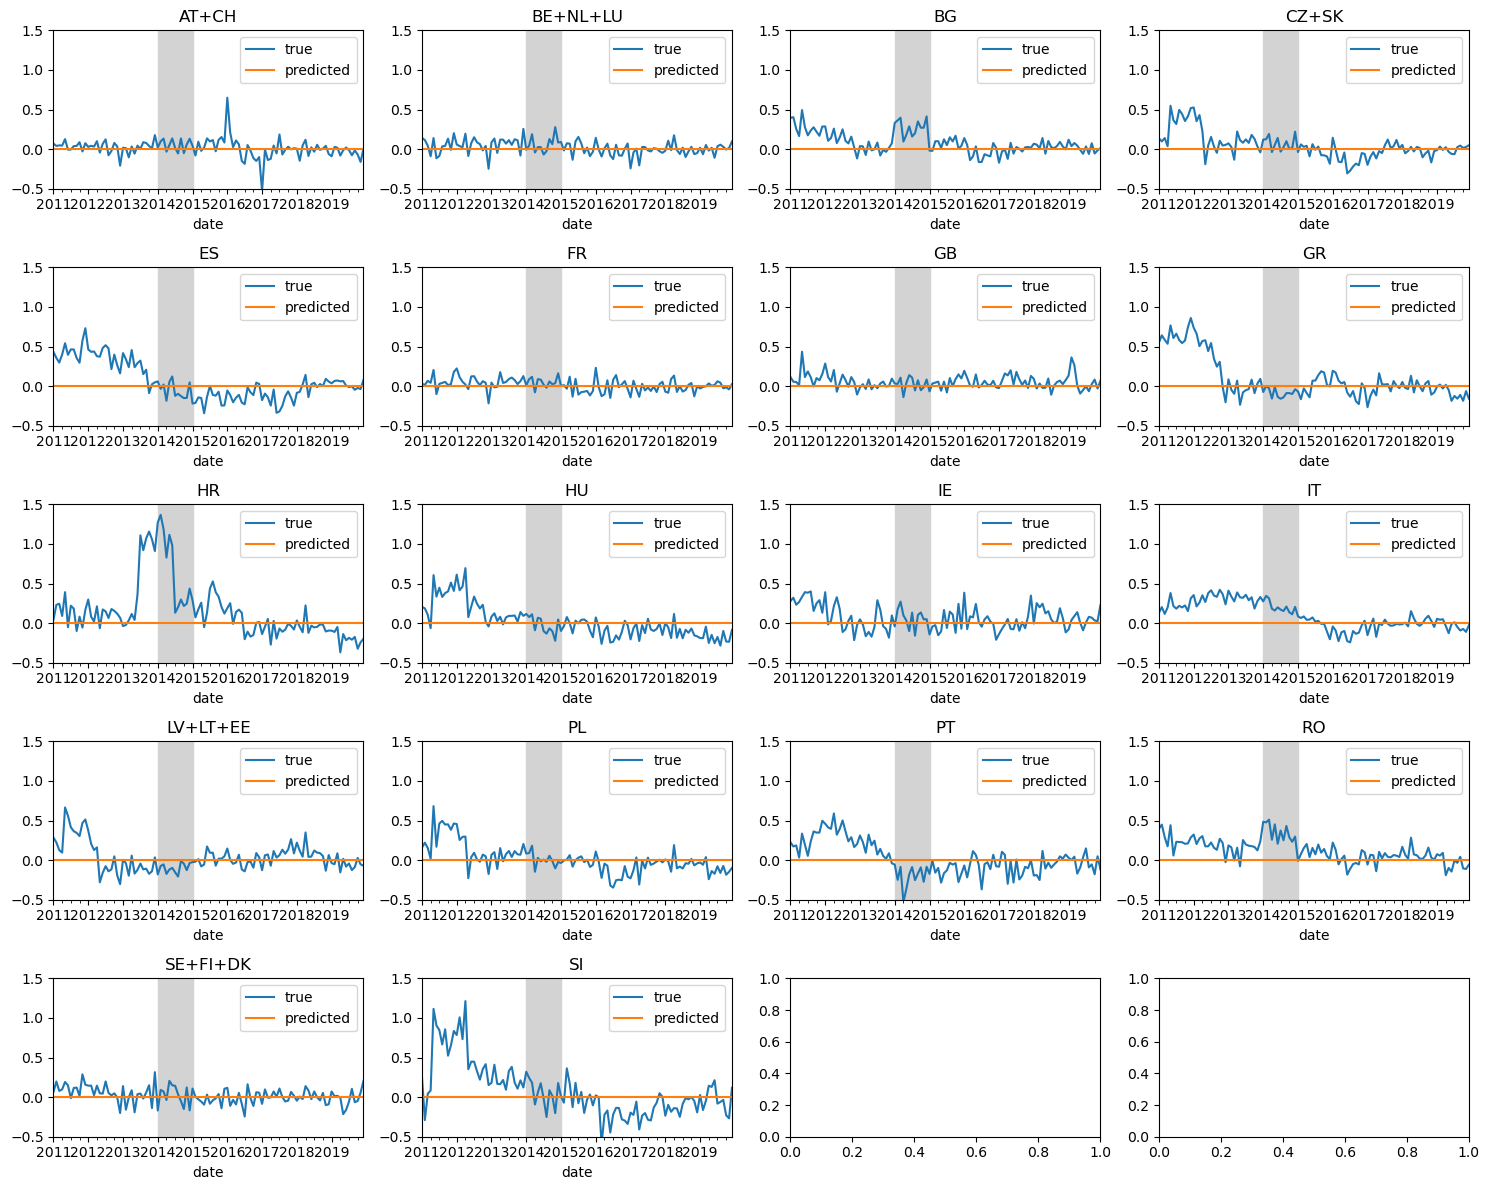

In [17]:
i = 0
reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
)
plt.show()


##### random walk

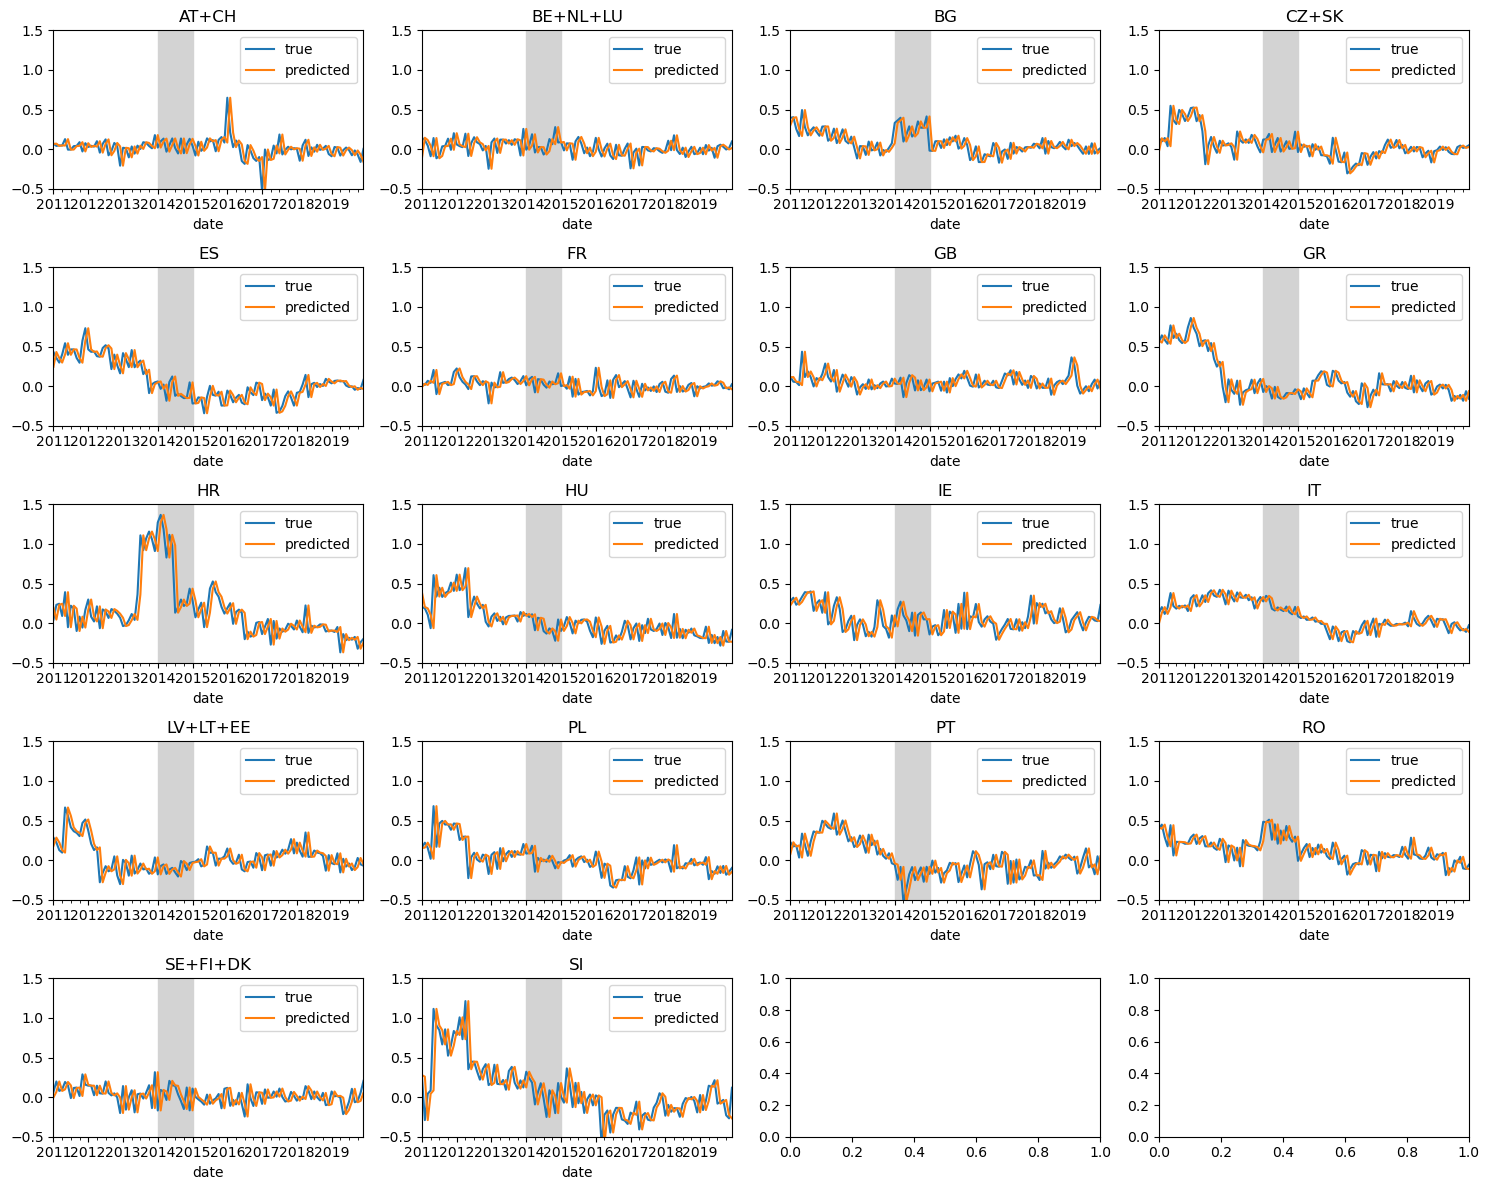

In [18]:
i = 1

reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
)
plt.show()

##### random walk w. delay

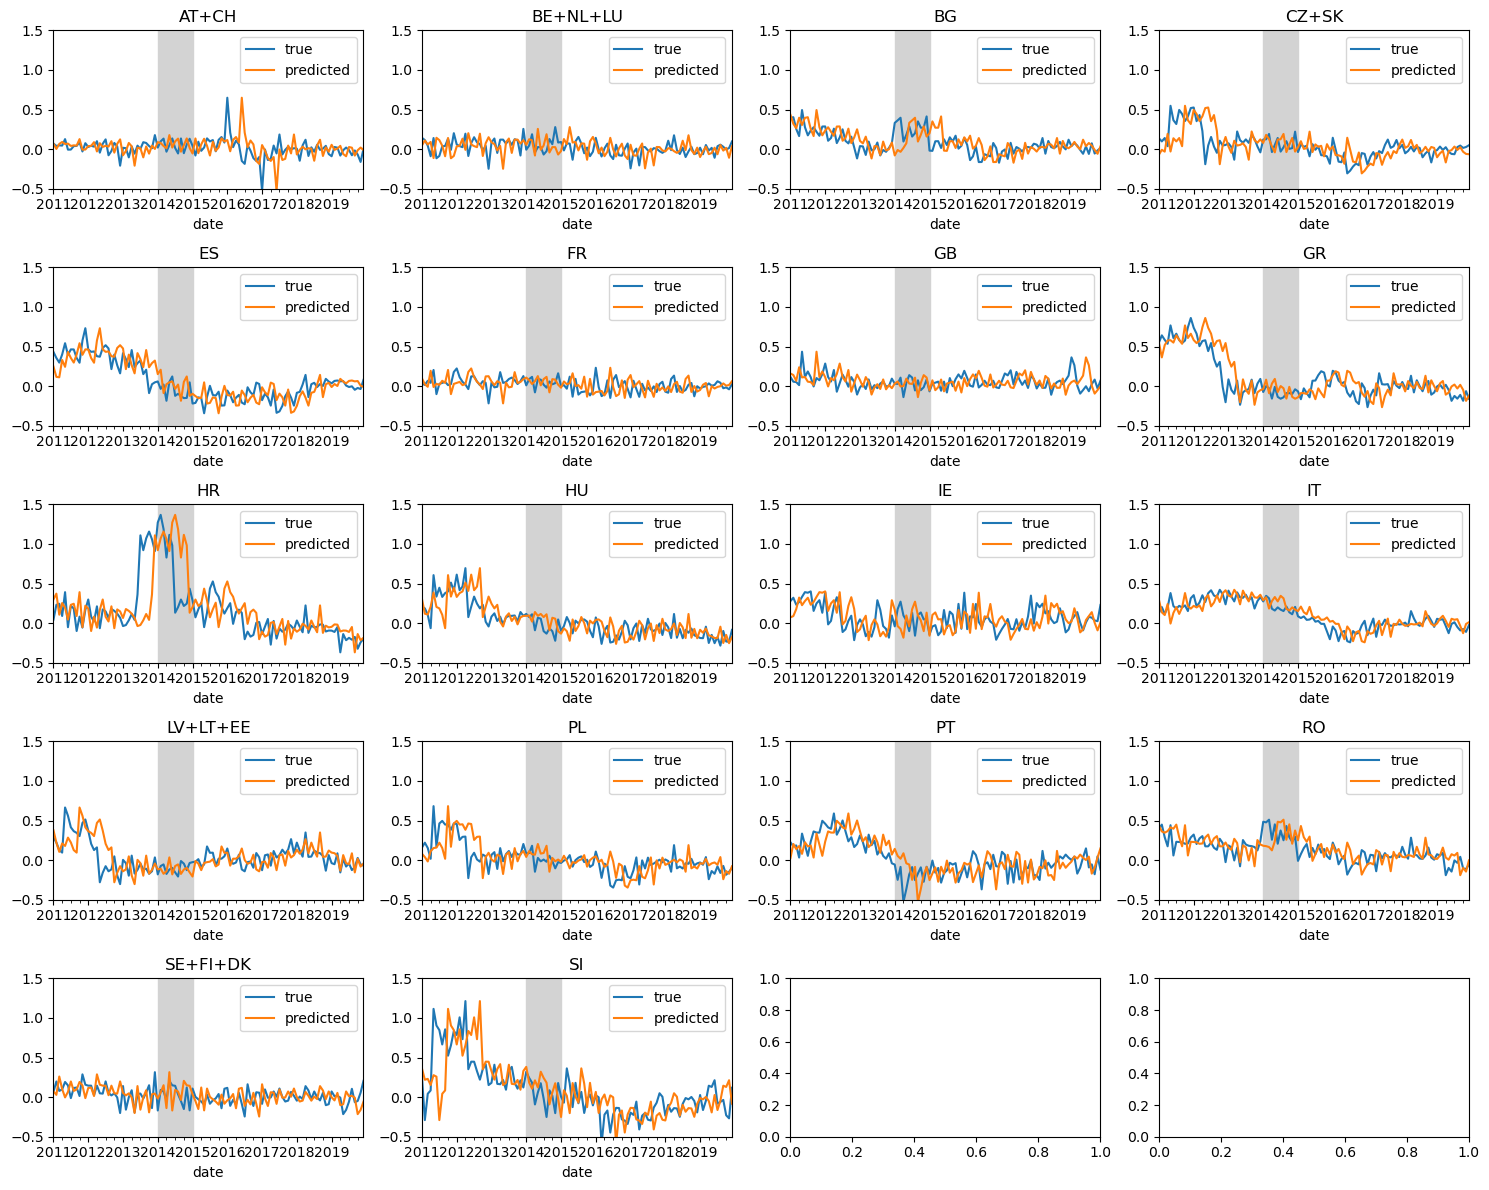

In [19]:
i = 2

reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2014", "2015"),
    t_max="2019",
)
plt.show()